# Feature Engineering

Feature Engineering Notebook

[1/8] Loading data from previous notebook...
✓ Training samples: 151,165
✓ Test samples: 34,394
✓ Target column: class

Attack distribution (from previous notebook):


attack_category
Normal    80792
Other     70373
Name: count, dtype: int64


[2/8] Separating features and targets...
Features: 41
Training samples: 151,165
Test samples: 34,394

[3/8] Encoding categorical features...
Categorical features: ['protocol_type', 'service', 'flag']
  protocol_type: 3 unique values
  service: 70 unique values
  flag: 11 unique values
✓ Encoded 3 categorical features

[4/8] Handling missing and infinite values...
Missing values in train: 0
Infinite values in train: 0
✓ Missing and infinite values handled

[5/8] Feature selection analysis...

Removing zero-variance features...
Found 1 zero-variance features

Removing highly correlated features (>0.95)...
Found 6 highly correlated features

✓ Final feature count: 34

Calculating feature importance...

Top 15 most important features:


src_bytes                      0.566266
service                        0.469851
dst_bytes                      0.441947
flag                           0.371411
same_srv_rate                  0.370115
diff_srv_rate                  0.358514
dst_host_srv_count             0.337470
dst_host_same_srv_rate         0.312922
logged_in                      0.293670
dst_host_diff_srv_rate         0.284875
serror_rate                    0.280877
count                          0.265343
dst_host_srv_diff_host_rate    0.187509
dst_host_count                 0.147364
dst_host_same_src_port_rate    0.131232
dtype: float64

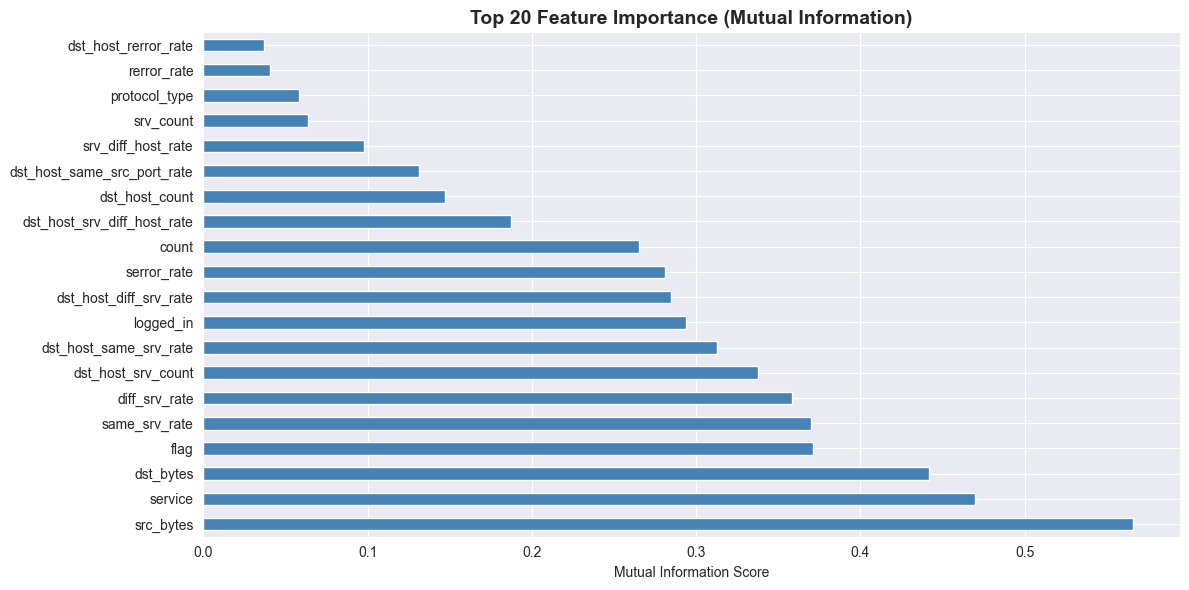


[7/8] Scaling features...
✓ Features scaled using StandardScaler


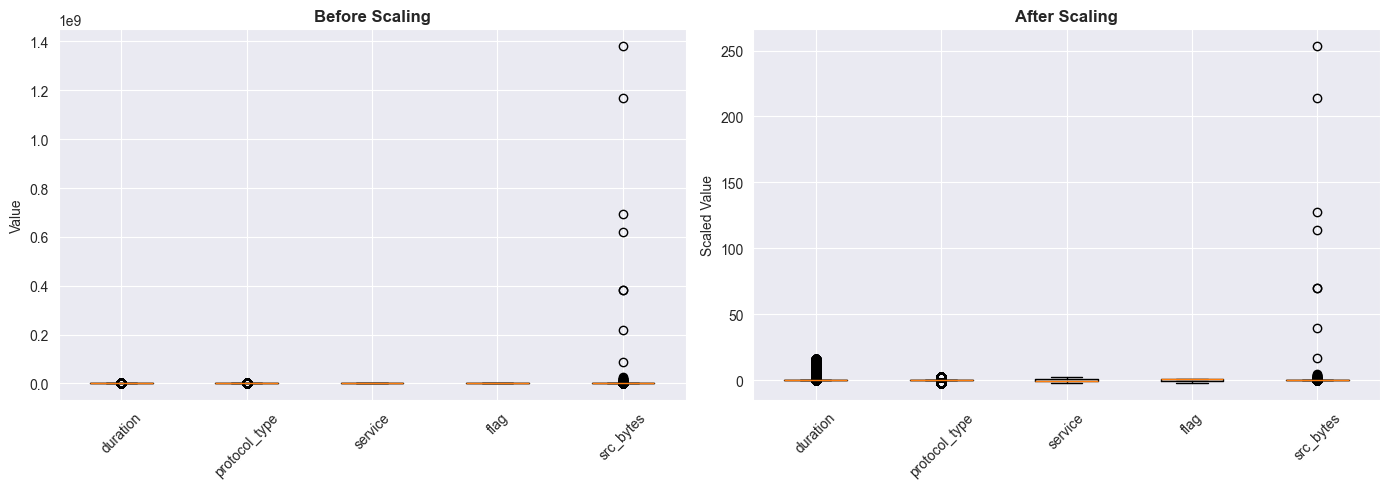


[8/8] Handling class imbalance with SMOTE...

Original class distribution:
Normal: 80,792 (53.4%)
Attack: 70,373 (46.6%)

Balanced class distribution:
Normal: 80,792 (50.0%)
Attack: 80,792 (50.0%)


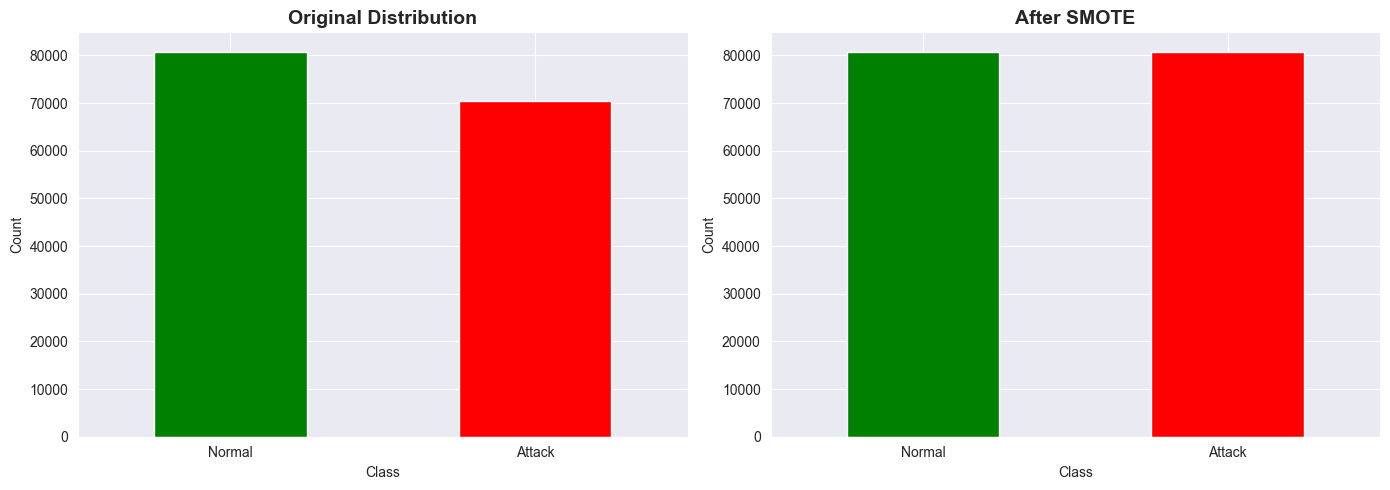


[Optional] Dimensionality reduction with PCA...

Components needed for 95% variance: 25 (out of 34)


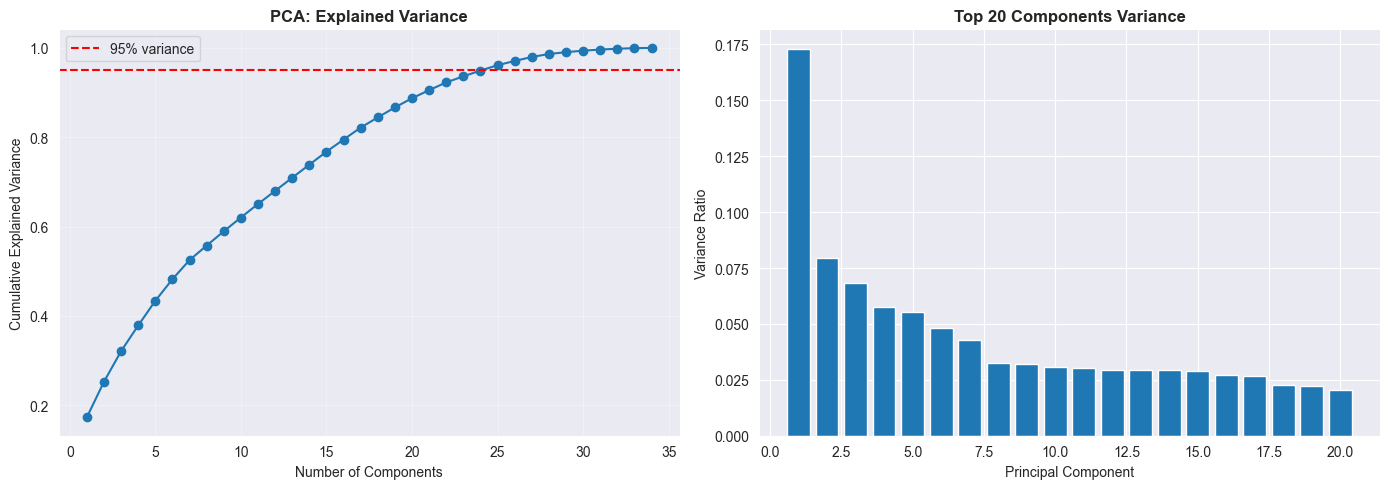


Saving processed features...
✓ Processed data saved
✓ Scaler and encoders saved

FEATURE ENGINEERING SUMMARY

Original Features: 41
After Selection: 34
Categorical Features Encoded: 3
Zero-Variance Features Removed: 1
Highly Correlated Features Removed: 6

Training Samples:
- Original: 151,165
- After SMOTE: 161,584

Test Samples: 34,394

Preprocessing Steps:
1. ✓ Label encoding for categorical features
2. ✓ Infinite/missing value handling
3. ✓ Zero-variance feature removal
4. ✓ Highly correlated feature removal
5. ✓ Feature scaling (StandardScaler)
6. ✓ Class imbalance handling (SMOTE)

Ready for Model Training! 🚀

Next: Open 03_model_training.ipynb


In [4]:
# ============================================================================
# PART 1: IMPORTS AND SETUP
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import json
from datasets import load_dataset
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
import joblib
import os

warnings.filterwarnings('ignore')
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Feature Engineering Notebook")
print("="*80)

# Create output directory
os.makedirs('../outputs/figures', exist_ok=True)

# ============================================================================
# PART 2: LOAD PREPROCESSED DATA FROM NOTEBOOK 01
# ============================================================================

print("\n[1/8] Loading data from previous notebook...")

# Load the data with labels created in 01_data_exploration.ipynb
df_train = pd.read_csv('../data/processed/train_with_labels.csv')
df_test = pd.read_csv('../data/processed/test_with_labels.csv')

print(f"✓ Training samples: {len(df_train):,}")
print(f"✓ Test samples: {len(df_test):,}")

# Load feature info
with open('../data/processed/feature_info.json', 'r') as f:
    feature_info = json.load(f)

target_col = feature_info['target_column']
print(f"✓ Target column: {target_col}")

# Verify labels exist
if 'is_attack' not in df_train.columns or 'attack_category' not in df_train.columns:
    print("⚠ Warning: Labels not found. Please run 01_data_exploration.ipynb first!")
    raise ValueError("Missing required columns from previous notebook")

print("\nAttack distribution (from previous notebook):")
display(df_train['attack_category'].value_counts())

# ============================================================================
# PART 3: SEPARATE FEATURES
# ============================================================================

print("\n[2/8] Separating features and targets...")

# Exclude columns
exclude_cols = [target_col, 'is_attack', 'attack_category']
if 'difficulty' in df_train.columns:
    exclude_cols.append('difficulty')

feature_cols = [col for col in df_train.columns if col not in exclude_cols]

X_train = df_train[feature_cols].copy()
y_train = df_train['is_attack'].copy()
y_train_multi = df_train['attack_category'].copy()

X_test = df_test[feature_cols].copy()
y_test = df_test['is_attack'].copy()

print(f"Features: {len(feature_cols)}")
print(f"Training samples: {len(X_train):,}")
print(f"Test samples: {len(X_test):,}")

# ============================================================================
# PART 4: HANDLE CATEGORICAL FEATURES
# ============================================================================

print("\n[3/8] Encoding categorical features...")

categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()
print(f"Categorical features: {categorical_cols}")

# Label Encoding
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    
    # Fit on combined data
    all_values = pd.concat([X_train[col], X_test[col]]).astype(str)
    le.fit(all_values)
    
    X_train[col] = le.transform(X_train[col].astype(str))
    X_test[col] = le.transform(X_test[col].astype(str))
    
    label_encoders[col] = le
    
    print(f"  {col}: {len(le.classes_)} unique values")

print(f"✓ Encoded {len(categorical_cols)} categorical features")

# ============================================================================
# PART 5: HANDLE MISSING AND INFINITE VALUES
# ============================================================================

print("\n[4/8] Handling missing and infinite values...")

# Check for issues
print(f"Missing values in train: {X_train.isnull().sum().sum()}")
print(f"Infinite values in train: {np.isinf(X_train.select_dtypes(include=[np.number])).sum().sum()}")

# Replace infinite with NaN
X_train = X_train.replace([np.inf, -np.inf], np.nan)
X_test = X_test.replace([np.inf, -np.inf], np.nan)

# Fill NaN with median
for col in X_train.columns:
    if X_train[col].isnull().sum() > 0:
        median_val = X_train[col].median()
        X_train[col].fillna(median_val, inplace=True)
        X_test[col].fillna(median_val, inplace=True)

print("✓ Missing and infinite values handled")

# ============================================================================
# PART 6: FEATURE SELECTION
# ============================================================================

print("\n[5/8] Feature selection analysis...")

# Remove zero variance features
print("\nRemoving zero-variance features...")
variance = X_train.var()
zero_var_features = variance[variance == 0].index.tolist()

if zero_var_features:
    print(f"Found {len(zero_var_features)} zero-variance features")
    X_train = X_train.drop(zero_var_features, axis=1)
    X_test = X_test.drop(zero_var_features, axis=1)
else:
    print("✓ No zero-variance features found")

# Remove highly correlated features
print("\nRemoving highly correlated features (>0.95)...")
corr_matrix = X_train.corr().abs()
upper_triangle = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

to_drop = [col for col in upper_triangle.columns if any(upper_triangle[col] > 0.95)]
print(f"Found {len(to_drop)} highly correlated features")

if to_drop:
    X_train = X_train.drop(to_drop, axis=1)
    X_test = X_test.drop(to_drop, axis=1)

print(f"\n✓ Final feature count: {X_train.shape[1]}")

# Feature importance using mutual information
print("\nCalculating feature importance...")
mi_scores = mutual_info_classif(X_train, y_train, random_state=42)
mi_scores = pd.Series(mi_scores, index=X_train.columns).sort_values(ascending=False)

print("\nTop 15 most important features:")
display(mi_scores.head(15))

# Visualize top features
fig, ax = plt.subplots(figsize=(12, 6))
mi_scores.head(20).plot(kind='barh', ax=ax, color='steelblue')
ax.set_title('Top 20 Feature Importance (Mutual Information)', fontsize=14, fontweight='bold')
ax.set_xlabel('Mutual Information Score')
plt.tight_layout()
plt.savefig('../outputs/figures/feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# PART 8: FEATURE SCALING
# ============================================================================

print("\n[7/8] Scaling features...")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✓ Features scaled using StandardScaler")

# Visualize scaling effect
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before scaling
axes[0].boxplot([X_train[col] for col in X_train.columns[:5]], labels=X_train.columns[:5])
axes[0].set_title('Before Scaling', fontweight='bold')
axes[0].set_ylabel('Value')
axes[0].tick_params(axis='x', rotation=45)

# After scaling
axes[1].boxplot([X_train_scaled[:, i] for i in range(5)], labels=X_train.columns[:5])
axes[1].set_title('After Scaling', fontweight='bold')
axes[1].set_ylabel('Scaled Value')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('../outputs/figures/scaling_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# PART 9: CLASS IMBALANCE HANDLING
# ============================================================================

print("\n[8/8] Handling class imbalance with SMOTE...")

print("\nOriginal class distribution:")
print(f"Normal: {sum(y_train==0):,} ({sum(y_train==0)/len(y_train)*100:.1f}%)")
print(f"Attack: {sum(y_train==1):,} ({sum(y_train==1)/len(y_train)*100:.1f}%)")

# Apply SMOTE
smote = SMOTE(random_state=42, k_neighbors=5)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

print("\nBalanced class distribution:")
print(f"Normal: {sum(y_train_balanced==0):,} ({sum(y_train_balanced==0)/len(y_train_balanced)*100:.1f}%)")
print(f"Attack: {sum(y_train_balanced==1):,} ({sum(y_train_balanced==1)/len(y_train_balanced)*100:.1f}%)")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

pd.Series(y_train).value_counts().plot(kind='bar', ax=axes[0], color=['green', 'red'])
axes[0].set_title('Original Distribution', fontweight='bold', fontsize=14)
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['Normal', 'Attack'], rotation=0)

pd.Series(y_train_balanced).value_counts().plot(kind='bar', ax=axes[1], color=['green', 'red'])
axes[1].set_title('After SMOTE', fontweight='bold', fontsize=14)
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Count')
axes[1].set_xticklabels(['Normal', 'Attack'], rotation=0)

plt.tight_layout()
plt.savefig('../outputs/figures/class_balance.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# PART 10: DIMENSIONALITY ANALYSIS (OPTIONAL)
# ============================================================================

print("\n[Optional] Dimensionality reduction with PCA...")

pca = PCA()
pca.fit(X_train_scaled)

# Explained variance
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Find components for 95% variance
n_components_95 = np.argmax(explained_variance >= 0.95) + 1
print(f"\nComponents needed for 95% variance: {n_components_95} (out of {X_train_scaled.shape[1]})")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(range(1, len(explained_variance)+1), explained_variance, marker='o')
axes[0].axhline(y=0.95, color='r', linestyle='--', label='95% variance')
axes[0].set_xlabel('Number of Components')
axes[0].set_ylabel('Cumulative Explained Variance')
axes[0].set_title('PCA: Explained Variance', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].bar(range(1, 21), pca.explained_variance_ratio_[:20])
axes[1].set_xlabel('Principal Component')
axes[1].set_ylabel('Variance Ratio')
axes[1].set_title('Top 20 Components Variance', fontweight='bold')

plt.tight_layout()
plt.savefig('../outputs/figures/pca_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# PART 11: SAVE PROCESSED DATA
# ============================================================================

print("\nSaving processed features...")

# Save as numpy arrays
np.save('../data/processed/X_train_balanced.npy', X_train_balanced)
np.save('../data/processed/y_train_balanced.npy', y_train_balanced)
np.save('../data/processed/X_test_scaled.npy', X_test_scaled)
np.save('../data/processed/y_test.npy', y_test.values)

# Save preprocessing objects
os.makedirs('../models', exist_ok=True)
joblib.dump(scaler, '../models/scaler.pkl')
joblib.dump(label_encoders, '../models/label_encoders.pkl')
joblib.dump(X_train.columns.tolist(), '../models/feature_columns.pkl')

print("✓ Processed data saved")
print("✓ Scaler and encoders saved")

# ============================================================================
# SUMMARY
# ============================================================================

print("\n" + "="*80)
print("FEATURE ENGINEERING SUMMARY")
print("="*80)

summary = f"""
Original Features: {len(feature_cols)}
After Selection: {X_train.shape[1]}
Categorical Features Encoded: {len(categorical_cols)}
Zero-Variance Features Removed: {len(zero_var_features)}
Highly Correlated Features Removed: {len(to_drop)}

Training Samples:
- Original: {len(df_train):,}
- After SMOTE: {len(X_train_balanced):,}

Test Samples: {len(X_test):,}

Preprocessing Steps:
1. ✓ Label encoding for categorical features
2. ✓ Infinite/missing value handling
3. ✓ Zero-variance feature removal
4. ✓ Highly correlated feature removal
5. ✓ Feature scaling (StandardScaler)
6. ✓ Class imbalance handling (SMOTE)

Ready for Model Training! 🚀
"""

print(summary)

print("="*80)
print("Next: Open 03_model_training.ipynb")
print("="*80)